In [1]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 31 19:40:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8    18W / 100W |    890MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gymnasium

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install stable_baselines3

Defaulting to user installation because normal site-packages is not writeable


In [4]:
#########################################################################
## LIBRERIAS NECESARIAS
#########################################################################
import tensorflow as tf
import gymnasium as gym
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
import copy
import torch
from sklearn.model_selection import train_test_split

import sys

import os
from stable_baselines3.common.vec_env import DummyVecEnv

2023-12-31 19:40:37.189304: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-31 19:40:37.190335: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 19:40:37.213146: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 19:40:37.214108: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-31 19:40:37.651247: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [5]:
############################################################################
## Variables globales (hiperparámetros)
###########################################################################
EPOCHS=1

EPISODES=10
EPISODES_EVALUATE_G=50

TOTAL_TIMESTEPS_PPO_GENERATOR=250
LEARNING_RATE=0.001

# GYM Acrobot

In [6]:
# Definimos el entorno
env= gym.make('Acrobot-v1')

# Obtenemos el espacio de estados y acciones del entorno
ob_space=env.observation_space
ac_space=env.action_space

# Mostramos el número de acciones del entorno
print(env.action_space.n)
# Mostramos el número de observaciones del entorno
print(ob_space.shape[0])

3
6


# Discriminador

## Red neuronal del Discriminador

In [7]:
################################################################################################################################################
# Red neuronal del Discriminador
################################################################################################################################################

# Input: secuencias [s,a] reales o sintéticas, de longitud ob_space.shape[0] + ac_space.n.
# Output: probabilidad de que la secuencia sea real, valor perteneciente al intervalo [0,1]
discriminator_net=keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0] + ac_space.n)),
        layers.Dense(units=7,activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=7,activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=7, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

Model: "discriminator_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 7)           70        
                                                                 
 layer2 (Dense)              (None, None, 7)           56        
                                                                 
 layer3 (Dense)              (None, None, 7)           56        
                                                                 
 prob (Dense)                (None, None, 1)           8         
                                                                 
Total params: 190 (760.00 Byte)
Trainable params: 190 (760.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-31 19:40:39.306430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-31 19:40:39.306708: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Función de pérdida del Discriminador

In [8]:
#########################################################################################################
# Función de pérdida del Discriminador
#########################################################################################################

# prob1=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia REAL [s,a, s', r] de la base de datos
# prob2=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia FALSA [s,a, s', r]
def loss_fn_D(prob1, prob2):

    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REAL
    loss_expert = tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1, 0.01, 1)))

    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent = tf.reduce_mean(tf.math.log(tf.clip_by_value(1 - prob2, 0.01,1)))

    loss_expert = tf.cast(loss_expert, dtype=tf.float32)
    loss_agent = tf.cast(loss_agent, dtype=tf.float32)

    loss = loss_expert + loss_agent

    loss = -loss

    return loss

## Clase del Discriminador

In [9]:
#########################################################################################
# Clase DISCRIMINADOR
########################################################################################
class Discriminator:
    def __init__(self, env, discriminator_net, expert_s, expert_a, agent_s, agent_a):
        # -Red neuronal del Discriminador
        self.discriminator_net=discriminator_net
        # -Experto: [s,a]
        self.expert_s=expert_s
        self.expert_a=expert_a
        expert_a_one_hot=tf.one_hot(self.expert_a,depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot+= tf.random.normal(tf.shape(expert_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.expert_s_a=tf.concat([self.expert_s,expert_a_one_hot],axis=1)

        # -Agente:  [s,a]
        self.agent_s=agent_s
        self.agent_a=agent_a
        agent_a_one_hot=tf.one_hot(self.agent_a,depth=env.action_space.n)
        agent_a_one_hot+= tf.random.normal(tf.shape(agent_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.agent_s_a=tf.concat([self.agent_s,agent_a_one_hot],axis=1)



        # Calculamos la salida de la red para [s,a] del experto y del agente ya que lo necesitamos para reward

        # -Salida de la red neuronal Discriminador para [s,a] expertos(verdaderos)
        self.prob_expert=self.discriminator_net(self.expert_s_a)

        # -Salida  de la red neuronal Discrimiinador para [s,a] Agente(falsos)
        self.prob_agent=self.discriminator_net(self.agent_s_a)

        #-Recompensa obtenida cuando el Agente realiza [s,a] falsas
        self.rewards=tf.math.log(tf.clip_by_value(self.prob_agent,1e-10,1)) #log(P(expert|s,a)) cuando mas grande es mejor el agente


    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards


# Generador

## Redes neuronales del Generador

In [10]:
#####################################################################################################
# Red neuronal del Generador donde se producen acciones
####################################################################################################

# Input: estados, listas de tamaño 6, s=[s1,s2,s3,s4,s5,s6]
# Output: acciones, listas de tamaño 3, a=[a1,a2,a3]
generator_net_Act=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=5, activation=tf.tanh,name='layer1'),
            layers.Dense(units=5, activation=tf.tanh, name='layer2'),
            layers.Dense(units=3, activation=tf.tanh, name='layer3'),
            layers.Dense(units=3, activation=tf.nn.softmax, name='layer4')

        ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 5)           35        
                                                                 
 layer2 (Dense)              (None, None, 5)           30        
                                                                 
 layer3 (Dense)              (None, None, 3)           18        
                                                                 
 layer4 (Dense)              (None, None, 3)           12        
                                                                 
Total params: 95 (380.00 Byte)
Trainable params: 95 (380.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
#############################################################################################################
# Red neuronal del Generador donde se producen v_pred
#############################################################################################################

# Input: estados, listas de tamaño 6, s=[s1,s2,s3,s4.s5,s6]
# Output: v_pred, listas de tamaño 1, v_pred
generator_net_v_preds=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=5, activation=tf.tanh,name='layer1'),
            layers.Dense(units=5, activation=tf.tanh, name='layer2'),
            layers.Dense(units=1, activation=None, name='layer3'),
        ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()

Model: "generator_v_preds"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 5)           35        
                                                                 
 layer2 (Dense)              (None, None, 5)           30        
                                                                 
 layer3 (Dense)              (None, None, 1)           6         
                                                                 
Total params: 71 (284.00 Byte)
Trainable params: 71 (284.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Función de pérdida del Generador

In [12]:
##################################################################################################################
# Función de pérdida del Generador: función objetivo de PPO "clipped surrogated"
#################################################################################################################
def loss_fn_ppo(act_probs,act_probs_old,gaes,clip_value=0.2):
    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)

    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del Generador

In [13]:
#################################################################################################################
# Clase del GENERADOR: política con su optimizador PPO
################################################################################################################

# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase Policy_net en lugar de generator
class Policy_net:
  def __init__(self, name: str, env, obs):
        """
        env: gym env
        obs:
        """
        # -Entorno
        self.env=env

        env.reset()

        # -Modelo PPO: algoritmo de Optimización de Política Proximal
        self.model=PPO(policy="MlpPolicy", env=env, verbose=0)


        self.model.learn(total_timesteps=TOTAL_TIMESTEPS_PPO_GENERATOR)

        # -Observación inicial a partir de la cual se crean las acciones iniciales haciendo uso de las redes neuronales del generador
        self.obs=np.reshape(np.array(obs),(1,ob_space.shape[0]))

        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs =generator_net_Act(self.obs)
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)



  # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
  # La elección de la acción puede ser estocástica o determinística
  def act(self, stochastic=True):
      if stochastic:
          return self.act_stochastic, self.v_preds
      else:
          return self.act_deterministic, self.v_preds

  def get_action_prob(self):
      return self.act_probs

  def get_v_preds(self):
      return self.v_preds

  def get_obs(self):
      return self.obs

  def get_model(self):
      return self.model

  def get_trainable_variables(self):
      return self.model.get_parameters()

  # Generar [s,a] falsos
  def generate_fakes(self):

      ob_space = env.observation_space
      reward = 0
      success_num = 0


      # Por cada episodio
      for iteration in range(EPISODES):
          # Inicializo todas las variables
          observations = []
          actions = []
          rewards = []
          run_policy_steps = 0

          truncated=False
          terminated=False


          #La primera acción de cada episodio se crea con la red neuronal

          obs,_=env.reset()

          Old_Policy = Policy_net('old_policy', env, obs=obs)

          act, v_pred = Old_Policy.act(stochastic=True)

          #Convertir de tensor a array
          if type(act)=='Tensor':
              # Crear una sesión de TensorFlow
              sess = tf.compat.v1.Session()

              # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
              act = sess.run(act)

              # Cerrar la sesión
              sess.close()

          if isinstance(act, tf.Tensor):
              act=act.numpy()

          elif isinstance(act, np.ndarray):
              act=act


          action=int(act)

          next_obs,reward,terminated,truncated, info=env.step(action)

          # --Actualización de variables: ojo no introduzco el estado y accion inicial, solo introduzco los de PPO
          observations.append(next_obs)  # S_0

          Policy = Policy_net('policy',env, obs=[next_obs]) # tenemos una política entrenada

          # Por cada steps en cada episodio, mientras no se llegue a un estado terminal o un estado malo
          while terminated!= True and truncated!= True:
              # --Aumentar el numero de steps
              run_policy_steps += 1

              # --Política para ver la acción asociada al estado
              # Las observaciones son un de la forma [[s_0,s_1,s_2,s_3]] por eso su tamaño es (1,4)
              action, states_oc = Policy.get_model().predict(next_obs)

              action=int(action)

              # --Muevo al Agente al siguiente estado
              next_obs,reward,terminated,truncated,info=env.step(action)
                
              # --Actualización de variables
              actions.append(action) # A_i-1
              rewards.append(reward) # R_i-1

              # --Si llegamos a un estado final, el juego ha finalizado!!!
              # --Se configura el tablero de nuevo
              if terminated== True or truncated==True:
                  obs = env.reset()
                  reward = -1
                  break
              else:
                  observations.append(next_obs) # O_i
                  self.obs = next_obs

          # Ver si el episodio ha obtendo una recompensa total igual o superior a 195
          if sum(rewards) >= 195:
              success_num += 1
              if success_num >= 100:
                  break
          else:
              success_num = 0


      observations = np.reshape(observations, newshape=[-1] + list(ob_space.shape))
      actions = np.array(actions).astype(dtype=np.int32)


      return observations, actions, rewards, Old_Policy, Policy

In [14]:
##########################################################################################################
# Clase PPOTrain
##########################################################################################################
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, cálculo de gradiente y función de pérdida del PPO para después usarlo en el generador de la GAN

class PPOTrain:
  def __init__(self, Policy, Old_Policy, obs, actions, rewards, gamma=0.95, clip_value=0.2, c_1=1, c_2=0.01):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs=obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()


        policy_name = "policy"
        old_policy_name="policy"

        policy_dict_ = self.pi_trainable[policy_name]
        old_policy_dict_=self.old_pi_trainable[old_policy_name]

        self.pi=[]
        if policy_name in self.pi_trainable and old_policy_name in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy en policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print(f"No se encontró la política con el nombre: {policy_name}")


        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos nuevos pi_trainable


        self.actions = actions
        self.rewards=rewards
        self.v_preds=self.Old_Policy.get_v_preds()
        self.v_preds_next=self.Policy.get_v_preds()

        #  generative advantage estimator(lambda = 1), ver ppo paper eq(11)
        self.gaes =self.get_gaes(self.rewards, self.v_preds, self.v_preds_next)

        act_probs =self.Policy.get_action_prob()
        act_probs_old =self.Old_Policy.get_action_prob()

        # la probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # la probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss=loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer =tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

  def loss_fn_G(self):
      return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

  def get_pi_trainable(self):
      return self.pi

  def get_optimizer(self):
      return self.optimizer

  def get_OldPolicy(self):
      return self.Old_Policy

  def get_Policy(self):
      return self.Policy

  def get_gaes(self, rewards, v_preds, v_preds_next):
      deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
      # calcular la estimación generative advantage (lambda = 1), ver ppo paper eq(11)
      gaes = copy.deepcopy(deltas)
      for t in reversed(range(len(gaes) - 1)):  # # es T-1, donde T es time step con el que se ejecuta la política
          gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
      return gaes

# GAIL

In [15]:
####################################################################################################################
# CLASE GAIL
####################################################################################################################
class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator=generator
        self.i=0
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self,d_optimizer, loss_fn_D ):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D=  loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
        len_real = X_test.shape[0]

        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        dataset_gen=np.concatenate([generate_observations,generate_a_one_hot],axis=1)


        len_fakes=dataset_gen.shape[0]

        # Compilamos el discriminador como CNN
        self.discriminator.discriminator_net.compile(optimizer=self.d_optimizer, loss=self.loss_fn_D, metrics=['accuracy'])

        # Evaluamos como CNN
        loss_real, acc_real=self.discriminator.discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake=self.discriminator.discriminator_net.evaluate(dataset_gen,tf.ones((len_fakes,1)), batch_size=len_fakes, verbose=1)

        print('>Loss real: ')
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)


    # Evaluación del generador
    def evaluate_G(self):
        # Definimos el entorno
        env= gym.make('Acrobot-v1')

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen la recompensa
        rewards=[]

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated=False
            terminated=False
            R=0.0
            reward=0.0

            # Estado inicial del juego
            obs,_=env.reset()

            #Interactuamos con el Entorno hasta que lleguemos a un estado final
            while terminated!= True and truncated!=True:
                action, _=self.generator.get_model().predict(obs)
                obs,reward,terminated,truncated, info=env.step(int(action))
                print(reward)
                # Incremento la recompensa del episodio i al haber ejecutado el step
                R+=reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
            print("Episode  {} Total reward: {}".format(episode,R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices,rewards)
        plt.show()

        return np.mean(rewards)

    def train_step(self, X_train):


        # 1) Generamos secuencias falsas [s,a]
        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
          generate_a_one_hot_resized = np.resize(generate_a_one_hot, (generate_observations.shape[0], ac_space.n))
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

        # 2) Seleccionamos la muestra de datos generador con la que vamos a trabajar en este  batch de entrenamiento  
        random_indices = np.random.choice(len(dataset_gen), size=min(BATCH_SIZE,len(dataset_gen)), replace=False)
        dataset_gen= dataset_gen[random_indices]

        ## 3) Obtenemos las secuencias reales [s,a] de los datos de entrenamiento y las combinamos
        combined_images = tf.concat([X_train, dataset_gen], axis=0) 


        # 4) Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido con tf.random.uniform
        labels = tf.concat([tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))


        ##############################################################################################################################################################
        # PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR
        #############################################################################################################################################################


        # Entrenamiento del discriminador con las [s,a, s', r] del agente(falsas o sintéticas) y del experto (reales) combinadas, esto es,
        # le pasamos un conjunto que tiene tanto secuencias reales como secuencias sintéticas
        with tf.GradientTape() as tape:
            predictions=np.zeros((2*BATCH_SIZE,6))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.getNet().trainable_weights)
        )


        ################################################################################################################################################################
        # PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA
        ###############################################################################################################################################################


        ppotrain=PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards, obs=generate_observations[0])


        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()


        g_loss = tf.cast(g_loss, dtype=tf.float32)

          
        ############################################################################################################################################################

        # Actualización de métricas del discriminador y generador
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(),
                    "g_loss": self.g_loss_metric.result()}




# Experimentación de GAIL con Acrobot

## Experimento 1


### Construcción de base de datos con 1 trayectoria

In [16]:
expert_observations = np.genfromtxt("observations_Acrobot_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.7708520e-01 -2.1284866e-01 -9.9287670e-01  1.1914617e-01
   4.5034285e+00 -3.0504138e+00]
 [ 7.8630270e-01  6.1784140e-01 -6.9435540e-01  7.1963220e-01
   4.1033060e+00 -3.7541158e+00]
 [ 1.9867054e-01  9.8006636e-01 -6.0039040e-03  9.9998200e-01
   2.9054150e+00 -3.7331226e+00]]
	Acciones reales: 
 [0 0 0 ... 0 1 1]


In [17]:
longitud_trayectoria = np.count_nonzero(expert_num_tray == 0)
print(longitud_trayectoria)

460


In [18]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [19]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.7213650e-01  2.3441560e-01 -8.0412865e-01  5.9445530e-01
   4.3846030e+00 -3.1870968e+00]
 [ 5.0865847e-01  8.6096835e-01 -2.0794137e-01  9.7814130e-01
   3.5154150e+00 -3.9439926e+00]
 [-6.0008243e-02  9.9819785e-01  5.5677474e-01  8.3066350e-01
   2.4302050e+00 -3.9388752e+00]]
	Acciones reales: 
 [0 0 0 0 2 2 0 2 2 1 2 1 1 1 0 1 0 0 0 1 2 2 2 2 1 0 1 1 2 2 2 1 0 2 1 2 1
 2 1 1 1 0 0 2 2 2 0 1 1 2 1 1 2 0 0 2 2 1 0 1 0 1 0 0 1 1 1 0 1 1 1 2 0 1
 1 2 1 2 0 0 0 2 0 0 1 1 2 1 0 1 2 0 0 0 2 2 0 0 1 0 1 2 2 2 2 1 1 1 1 0 0
 0 0 0 1 0 2 0 0 1 1 1 2 2 2 1 2 2 2 2 2 1 1 1 0 2 2 2 0 1 0 2 2 1 0 1 1 0
 0 2 2 1 2 0 1 0 1 2 1 1 0 2 0 1 0 2 1 1 2 1 1 1 1 2 2 0 1 1 0 0 2 1 1 2 0
 0 0 0 2 

### Separación de Train y Test

In [20]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997245  -0.02347029  0.9999985  ...  1.          0.
   0.        ]
 [ 0.9999358  -0.01132928  0.99917394 ...  1.          0.
   0.        ]
 [ 0.99959403  0.02849232  0.98998153 ...  1.          0.
   0.        ]
 ...
 [ 0.9721365   0.2344156  -0.80412865 ...  1.          0.
   0.        ]
 [ 0.50865847  0.86096835 -0.20794137 ...  1.          0.
   0.        ]
 [-0.06000824  0.99819785  0.55677474 ...  0.          0.
   1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 368
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 92


In [21]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [22]:
gan1=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [23]:
tf.config.run_functions_eagerly(True)
gan1.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [24]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [25]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

# Realiza 300 iteraciones con los datos de entrenamiento: la división da 0.8, he aproximado a 1 aunque realicemos menos de 300 iteraciones con los datos 
BATCH_SIZE= round(len(X_train)/300)

history=gan1.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)

/home/usuario/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


368/368 [==============================] - 11881s 32s/step - d_loss: 2.1109 - g_loss: 1.1751


### Evaluación de GAIL

In [26]:
# Evaluamos el Discriminador de GAIL en el TEST
gan1.evaluate_D(X_test)

1/1 [==============================] - 0s 14ms/step - loss: 0.0087 - accuracy: 0.0000e+00
>Loss real: 
0.011417916044592857
>Loss fake: 
0.008693819865584373


In [27]:
# Evaluamos al Generador 
rewardMean=gan1.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0



Recompensa de Media: -500.0 



## Experimento 2


### Construcción de base de datos con 2 trayectoria

In [28]:
expert_observations = np.genfromtxt("observations_Acrobot_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.7708520e-01 -2.1284866e-01 -9.9287670e-01  1.1914617e-01
   4.5034285e+00 -3.0504138e+00]
 [ 7.8630270e-01  6.1784140e-01 -6.9435540e-01  7.1963220e-01
   4.1033060e+00 -3.7541158e+00]
 [ 1.9867054e-01  9.8006636e-01 -6.0039040e-03  9.9998200e-01
   2.9054150e+00 -3.7331226e+00]]
	Acciones reales: 
 [0 0 0 ... 0 1 1]


In [29]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 1)
print(longitud_trayectoria)

960


In [30]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [31]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [-9.9973930e-01 -2.2832350e-02 -9.9583423e-01  9.1182450e-02
  -2.9107814e+00  9.7474100e-01]
 [-8.3992870e-01  5.4269683e-01 -9.9399394e-01 -1.0943528e-01
  -3.1799090e+00  1.1871023e+00]
 [-2.6855344e-01  9.6326476e-01 -8.9367867e-01 -4.4870758e-01
  -4.1497846e+00  2.5546220e+00]]
	Acciones reales: 
 [0 0 0 0 2 2 0 2 2 1 2 1 1 1 0 1 0 0 0 1 2 2 2 2 1 0 1 1 2 2 2 1 0 2 1 2 1
 2 1 1 1 0 0 2 2 2 0 1 1 2 1 1 2 0 0 2 2 1 0 1 0 1 0 0 1 1 1 0 1 1 1 2 0 1
 1 2 1 2 0 0 0 2 0 0 1 1 2 1 0 1 2 0 0 0 2 2 0 0 1 0 1 2 2 2 2 1 1 1 1 0 0
 0 0 0 1 0 2 0 0 1 1 1 2 2 2 1 2 2 2 2 2 1 1 1 0 2 2 2 0 1 0 2 2 1 0 1 1 0
 0 2 2 1 2 0 1 0 1 2 1 1 0 2 0 1 0 2 1 1 2 1 1 1 1 2 2 0 1 1 0 0 2 1 1 2 0
 0 0 0 2 

### Separación de Train y Test

In [32]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997245  -0.02347029  0.9999985  ...  1.          0.
   0.        ]
 [ 0.9999358  -0.01132928  0.99917394 ...  1.          0.
   0.        ]
 [ 0.99959403  0.02849232  0.98998153 ...  1.          0.
   0.        ]
 ...
 [-0.9997393  -0.02283235 -0.99583423 ...  1.          0.
   0.        ]
 [-0.8399287   0.54269683 -0.99399394 ...  0.          1.
   0.        ]
 [-0.26855344  0.96326476 -0.89367867 ...  0.          0.
   1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 768
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 192


In [33]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [34]:
gan2=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [35]:
tf.config.run_functions_eagerly(True)
gan2.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [36]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [37]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

# Realiza 300 iteraciones con los datos de entrenamiento: la división da 0.8, he aproximado a 1 aunque realicemos menos de 300 iteraciones con los datos 
BATCH_SIZE= round(len(X_train)/300)

history=gan2.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)

256/256 [==============================] - 8352s 33s/step - d_loss: 1.9109 - g_loss: 1.1854


### Evaluación de GAIL

In [38]:
# Evaluamos el Discriminador de GAIL en el TEST
gan2.evaluate_D(X_test)

1/1 [==============================] - 0s 15ms/step - loss: 1.3263e-04 - accuracy: 0.0000e+00
>Loss real: 
0.00030345789855346084
>Loss fake: 
0.0001326314959442243


In [39]:
# Evaluamos al Generador 
rewardMean=gan2.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0



Recompensa de Media: -492.58 



## Experimento 3


### Construcción de base de datos con 3 trayectoria

In [40]:
expert_observations = np.genfromtxt("observations_Acrobot_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.7708520e-01 -2.1284866e-01 -9.9287670e-01  1.1914617e-01
   4.5034285e+00 -3.0504138e+00]
 [ 7.8630270e-01  6.1784140e-01 -6.9435540e-01  7.1963220e-01
   4.1033060e+00 -3.7541158e+00]
 [ 1.9867054e-01  9.8006636e-01 -6.0039040e-03  9.9998200e-01
   2.9054150e+00 -3.7331226e+00]]
	Acciones reales: 
 [0 0 0 ... 0 1 1]


In [41]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 2)
print(longitud_trayectoria)

1460


In [42]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [43]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.7240806e-01  2.3328649e-01  2.1596944e-02 -9.9976677e-01
   2.6291930e+00 -4.8038630e+00]
 [ 7.6292515e-01  6.4648680e-01 -6.9224620e-01 -7.2166140e-01
   2.0070210e+00 -3.1044393e+00]
 [ 5.2513010e-01  8.5102195e-01 -9.4407547e-01 -3.2972947e-01
   1.0982001e+00 -1.6191447e+00]]
	Acciones reales: 
 [0 0 0 ... 1 1 2]


### Separación de Train y Test

In [44]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997245  -0.02347029  0.9999985  ...  1.          0.
   0.        ]
 [ 0.9999358  -0.01132928  0.99917394 ...  1.          0.
   0.        ]
 [ 0.99959403  0.02849232  0.98998153 ...  1.          0.
   0.        ]
 ...
 [ 0.97240806  0.23328649  0.02159694 ...  0.          1.
   0.        ]
 [ 0.76292515  0.6464868  -0.6922462  ...  0.          1.
   0.        ]
 [ 0.5251301   0.85102195 -0.94407547 ...  0.          0.
   1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1168
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 292


In [45]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [46]:
gan3=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [47]:
tf.config.run_functions_eagerly(True)
gan3.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [48]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [49]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

# Realiza 300 iteraciones con los datos de entrenamiento: la división da 0.8, he aproximado a 1 aunque realicemos menos de 300 iteraciones con los datos 
BATCH_SIZE= round(len(X_train)/300)

history=gan3.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)

292/292 [==============================] - 9614s 33s/step - d_loss: 1.9080 - g_loss: 1.2197


### Evaluación de GAIL

In [50]:
# Evaluamos el Discriminador de GAIL en el TEST
gan3.evaluate_D(X_test)

1/1 [==============================] - 0s 15ms/step - loss: 4.7992e-06 - accuracy: 0.0000e+00
>Loss real: 
1.5913932429612032e-06
>Loss fake: 
4.799191628990229e-06


In [51]:
# Evaluamos al Generador 
rewardMean=gan3.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0



Recompensa de Media: -500.0 



## Experimento 4


### Construcción de base de datos con 4 trayectoria

In [52]:
expert_observations = np.genfromtxt("observations_Acrobot_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.7708520e-01 -2.1284866e-01 -9.9287670e-01  1.1914617e-01
   4.5034285e+00 -3.0504138e+00]
 [ 7.8630270e-01  6.1784140e-01 -6.9435540e-01  7.1963220e-01
   4.1033060e+00 -3.7541158e+00]
 [ 1.9867054e-01  9.8006636e-01 -6.0039040e-03  9.9998200e-01
   2.9054150e+00 -3.7331226e+00]]
	Acciones reales: 
 [0 0 0 ... 0 1 1]


In [53]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 3)
print(longitud_trayectoria)

1960


In [54]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [55]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.5008755e-01 -3.1198340e-01  9.7989750e-01 -1.9950147e-01
   5.0885444e+00 -8.1916300e+00]
 [ 7.9206353e-01  6.1043870e-01 -4.2146347e-02 -9.9911150e-01
   4.4849760e+00 -5.5196220e+00]
 [ 1.0989964e-01  9.9394270e-01 -7.6583534e-01 -6.4303670e-01
   3.5014935e+00 -2.9474921e+00]]
	Acciones reales: 
 [0 0 0 ... 1 1 0]


### Separación de Train y Test

In [56]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997245  -0.02347029  0.9999985  ...  1.          0.
   0.        ]
 [ 0.9999358  -0.01132928  0.99917394 ...  1.          0.
   0.        ]
 [ 0.99959403  0.02849232  0.98998153 ...  1.          0.
   0.        ]
 ...
 [ 0.95008755 -0.3119834   0.9798975  ...  0.          1.
   0.        ]
 [ 0.79206353  0.6104387  -0.04214635 ...  0.          1.
   0.        ]
 [ 0.10989964  0.9939427  -0.76583534 ...  1.          0.
   0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1568
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 392


In [57]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [58]:
gan4=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [59]:
tf.config.run_functions_eagerly(True)
gan4.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [60]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [61]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

# Realiza 300 iteraciones con los datos de entrenamiento: la división da 0.8, he aproximado a 1 aunque realicemos menos de 300 iteraciones con los datos 
BATCH_SIZE= round(len(X_train)/300)

history=gan4.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)

314/314 [==============================] - 10302s 33s/step - d_loss: 1.8914 - g_loss: 1.2213


### Evaluación de GAIL

In [62]:
# Evaluamos el Discriminador de GAIL en el TEST
gan4.evaluate_D(X_test)

1/1 [==============================] - 0s 14ms/step - loss: 1.1077e-08 - accuracy: 0.0000e+00
>Loss real: 
1.0491661583955647e-07
>Loss fake: 
1.1076972228352133e-08


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


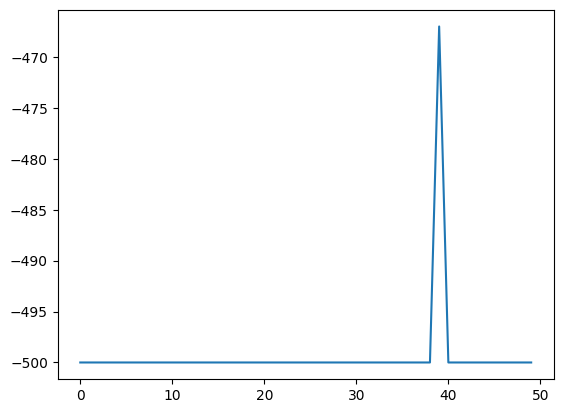


Recompensa de Media: -499.34 



In [63]:
# Evaluamos al Generador 
rewardMean=gan4.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 5


### Construcción de base de datos con 1 trayectoria

In [64]:
expert_observations = np.genfromtxt("observations_Acrobot_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.7708520e-01 -2.1284866e-01 -9.9287670e-01  1.1914617e-01
   4.5034285e+00 -3.0504138e+00]
 [ 7.8630270e-01  6.1784140e-01 -6.9435540e-01  7.1963220e-01
   4.1033060e+00 -3.7541158e+00]
 [ 1.9867054e-01  9.8006636e-01 -6.0039040e-03  9.9998200e-01
   2.9054150e+00 -3.7331226e+00]]
	Acciones reales: 
 [0 0 0 ... 0 1 1]


In [65]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 4)
print(longitud_trayectoria)

2446


In [66]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [67]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 8.8562980e-01 -4.6439192e-01 -9.8770285e-01 -1.5634286e-01
  -3.7118518e+00  4.4768734e+00]
 [ 4.2403686e-01 -9.0564495e-01 -5.3292080e-01 -8.4616520e-01
  -2.6977246e+00  4.0306610e+00]
 [ 8.4917090e-03 -9.9996394e-01  2.0029210e-01 -9.7973620e-01
  -1.6117811e+00  3.5626585e+00]]
	Acciones reales: 
 [0 0 0 ... 1 2 1]


### Separación de Train y Test

In [68]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997245  -0.02347029  0.9999985  ...  1.          0.
   0.        ]
 [ 0.9999358  -0.01132928  0.99917394 ...  1.          0.
   0.        ]
 [ 0.99959403  0.02849232  0.98998153 ...  1.          0.
   0.        ]
 ...
 [ 0.8856298  -0.46439192 -0.98770285 ...  0.          1.
   0.        ]
 [ 0.42403686 -0.90564495 -0.5329208  ...  0.          0.
   1.        ]
 [ 0.00849171 -0.99996394  0.2002921  ...  0.          1.
   0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1956
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 490


In [69]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [70]:
gan5=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [71]:
tf.config.run_functions_eagerly(True)
gan5.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [72]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [73]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

# Realiza 300 iteraciones con los datos de entrenamiento: la división da 0.8, he aproximado a 1 aunque realicemos menos de 300 iteraciones con los datos 
BATCH_SIZE= round(len(X_train)/300)

history=gan5.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)

280/280 [==============================] - 9210s 33s/step - d_loss: 1.9072 - g_loss: 1.1819


### Evaluación de GAIL

In [74]:
# Evaluamos el Discriminador de GAIL en el TEST
gan5.evaluate_D(X_test)

1/1 [==============================] - 0s 16ms/step - loss: 2.6374e-10 - accuracy: 0.0000e+00
>Loss real: 
1.0339583411678177e-08
>Loss fake: 
2.6373739303586774e-10


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


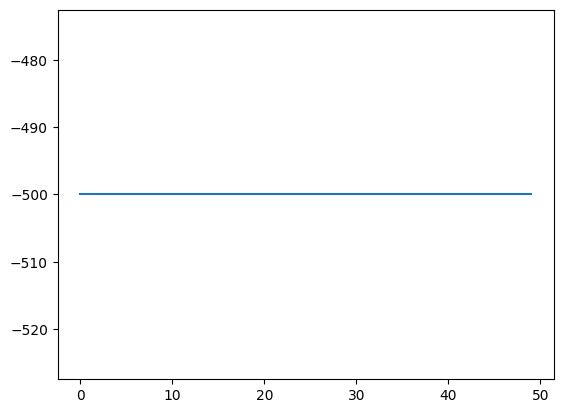


Recompensa de Media: -500.0 



In [75]:
# Evaluamos al Generador 
rewardMean=gan5.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 6


### Construcción de base de datos con 6 trayectoria

In [76]:
expert_observations = np.genfromtxt("observations_Acrobot_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.7708520e-01 -2.1284866e-01 -9.9287670e-01  1.1914617e-01
   4.5034285e+00 -3.0504138e+00]
 [ 7.8630270e-01  6.1784140e-01 -6.9435540e-01  7.1963220e-01
   4.1033060e+00 -3.7541158e+00]
 [ 1.9867054e-01  9.8006636e-01 -6.0039040e-03  9.9998200e-01
   2.9054150e+00 -3.7331226e+00]]
	Acciones reales: 
 [0 0 0 ... 0 1 1]


In [77]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 5)
print(longitud_trayectoria)

2775


In [78]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [79]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.0946555e-01 -4.1577926e-01  4.5207724e-01  8.9197880e-01
   2.7718540e+00  3.3587406e+00]
 [ 9.5942680e-01  2.8195786e-01  1.1545561e-01  9.9331266e-01
   4.1107087e+00  3.2768673e-01]
 [ 4.4038746e-01  8.9780784e-01  2.7791616e-01  9.6060530e-01
   3.9499035e+00 -1.6720645e+00]]
	Acciones reales: 
 [0 0 0 ... 2 0 0]


### Separación de Train y Test

In [80]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997245  -0.02347029  0.9999985  ...  1.          0.
   0.        ]
 [ 0.9999358  -0.01132928  0.99917394 ...  1.          0.
   0.        ]
 [ 0.99959403  0.02849232  0.98998153 ...  1.          0.
   0.        ]
 ...
 [ 0.90946555 -0.41577926  0.45207724 ...  0.          0.
   1.        ]
 [ 0.9594268   0.28195786  0.11545561 ...  1.          0.
   0.        ]
 [ 0.44038746  0.89780784  0.27791616 ...  1.          0.
   0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 2220
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 555


In [81]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [82]:
gan6=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [83]:
tf.config.run_functions_eagerly(True)
gan6.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [84]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [85]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

# Realiza 300 iteraciones con los datos de entrenamiento: la división da 0.8, he aproximado a 1 aunque realicemos menos de 300 iteraciones con los datos 
BATCH_SIZE= round(len(X_train)/300)

history=gan6.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)

318/318 [==============================] - 10304s 32s/step - d_loss: 1.8806 - g_loss: 1.2114


### Evaluación de GAIL

In [86]:
# Evaluamos el Discriminador de GAIL en el TEST
gan6.evaluate_D(X_test)

1/1 [==============================] - 0s 14ms/step - loss: 1.3187e-10 - accuracy: 0.0000e+00
>Loss real: 
5.369789057851904e-09
>Loss fake: 
1.3186869651793387e-10


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


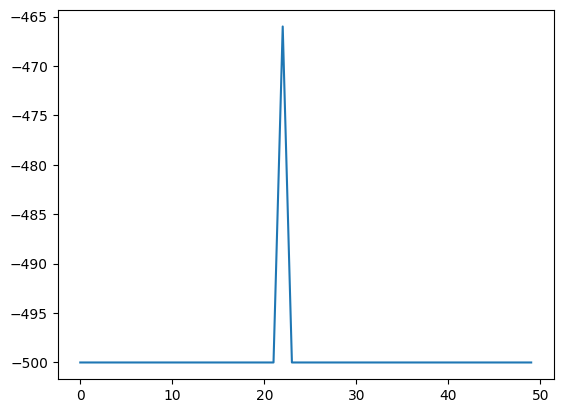


Recompensa de Media: -499.32 



In [87]:
# Evaluamos al Generador 
rewardMean=gan6.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 7


### Construcción de base de datos con 7 trayectoria

In [88]:
expert_observations = np.genfromtxt("observations_Acrobot_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.7708520e-01 -2.1284866e-01 -9.9287670e-01  1.1914617e-01
   4.5034285e+00 -3.0504138e+00]
 [ 7.8630270e-01  6.1784140e-01 -6.9435540e-01  7.1963220e-01
   4.1033060e+00 -3.7541158e+00]
 [ 1.9867054e-01  9.8006636e-01 -6.0039040e-03  9.9998200e-01
   2.9054150e+00 -3.7331226e+00]]
	Acciones reales: 
 [0 0 0 ... 0 1 1]


In [89]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 6)
print(longitud_trayectoria)

3275


In [90]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [91]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.99724500e-01 -2.34702920e-02  9.99998500e-01 -1.71937100e-03
  -2.04512180e-02 -1.31217770e-02]
 [ 9.99935800e-01 -1.13292770e-02  9.99173940e-01 -4.06384020e-02
   1.37956510e-01 -3.67119460e-01]
 [ 9.99594030e-01  2.84923240e-02  9.89981530e-01 -1.41196820e-01
   2.48752220e-01 -6.18880700e-01]
 ...
 [ 5.01903100e-01  8.64923830e-01 -9.92619340e-01  1.21272060e-01
  -2.24459300e+00  1.75669790e+00]
 [ 8.73893200e-01  4.86117960e-01 -9.46223800e-01 -3.23512880e-01
  -3.03083520e+00  2.73599340e+00]
 [ 9.93546300e-01 -1.13427006e-01 -5.68176500e-01 -8.22906730e-01
  -3.05015730e+00  3.60711150e+00]]
	Acciones reales: 
 [0 0 0 ... 0 0 2]


### Separación de Train y Test

In [92]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997245  -0.02347029  0.9999985  ...  1.          0.
   0.        ]
 [ 0.9999358  -0.01132928  0.99917394 ...  1.          0.
   0.        ]
 [ 0.99959403  0.02849232  0.98998153 ...  1.          0.
   0.        ]
 ...
 [ 0.5019031   0.86492383 -0.99261934 ...  1.          0.
   0.        ]
 [ 0.8738932   0.48611796 -0.9462238  ...  1.          0.
   0.        ]
 [ 0.9935463  -0.11342701 -0.5681765  ...  0.          0.
   1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 2620
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 655


In [93]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [94]:
gan7=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [95]:
tf.config.run_functions_eagerly(True)
gan7.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [96]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [97]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

# Realiza 300 iteraciones con los datos de entrenamiento: la división da 0.8, he aproximado a 1 aunque realicemos menos de 300 iteraciones con los datos 
BATCH_SIZE= round(len(X_train)/300)

history=gan7.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)

292/292 [==============================] - 9415s 32s/step - d_loss: 1.8975 - g_loss: 1.2046


### Evaluación de GAIL

In [98]:
# Evaluamos el Discriminador de GAIL en el TEST
gan7.evaluate_D(X_test)

1/1 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
1.637990632019637e-09
>Loss fake: 
0.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


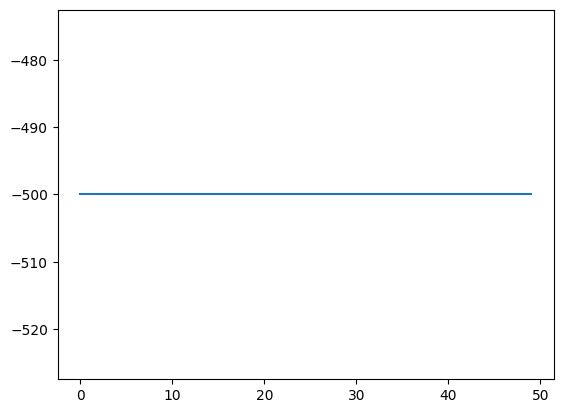


Recompensa de Media: -500.0 



In [99]:
# Evaluamos al Generador 
rewardMean=gan7.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 8


### Construcción de base de datos con 8 trayectoria

In [100]:
expert_observations = np.genfromtxt("observations_Acrobot_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.7708520e-01 -2.1284866e-01 -9.9287670e-01  1.1914617e-01
   4.5034285e+00 -3.0504138e+00]
 [ 7.8630270e-01  6.1784140e-01 -6.9435540e-01  7.1963220e-01
   4.1033060e+00 -3.7541158e+00]
 [ 1.9867054e-01  9.8006636e-01 -6.0039040e-03  9.9998200e-01
   2.9054150e+00 -3.7331226e+00]]
	Acciones reales: 
 [0 0 0 ... 0 1 1]


In [101]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 7)
print(longitud_trayectoria)

3775


In [102]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [103]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 5.6843144e-01 -8.2273060e-01  9.4900274e-01 -3.1526790e-01
   5.2360606e-01 -4.3537250e+00]
 [ 6.9615340e-01 -7.1789300e-01  3.6979505e-01 -9.2911330e-01
   1.0809274e+00 -4.2661650e+00]
 [ 8.5896856e-01 -5.1202840e-01 -4.3318070e-01 -9.0130710e-01
   1.5574545e+00 -4.0153203e+00]]
	Acciones reales: 
 [0 0 0 ... 1 1 1]


### Separación de Train y Test

In [104]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997245  -0.02347029  0.9999985  ...  1.          0.
   0.        ]
 [ 0.9999358  -0.01132928  0.99917394 ...  1.          0.
   0.        ]
 [ 0.99959403  0.02849232  0.98998153 ...  1.          0.
   0.        ]
 ...
 [ 0.56843144 -0.8227306   0.94900274 ...  0.          1.
   0.        ]
 [ 0.6961534  -0.717893    0.36979505 ...  0.          1.
   0.        ]
 [ 0.85896856 -0.5120284  -0.4331807  ...  0.          1.
   0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3020
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 755


In [105]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [106]:
gan8=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [107]:
tf.config.run_functions_eagerly(True)
gan8.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [108]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [109]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

# Realiza 300 iteraciones con los datos de entrenamiento: la división da 0.8, he aproximado a 1 aunque realicemos menos de 300 iteraciones con los datos 
BATCH_SIZE= round(len(X_train)/300)

history=gan8.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)

302/302 [==============================] - 9722s 32s/step - d_loss: 1.8996 - g_loss: 1.2039


### Evaluación de GAIL

In [110]:
# Evaluamos el Discriminador de GAIL en el TEST
gan8.evaluate_D(X_test)

1/1 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
1.4999845809882117e-09
>Loss fake: 
0.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


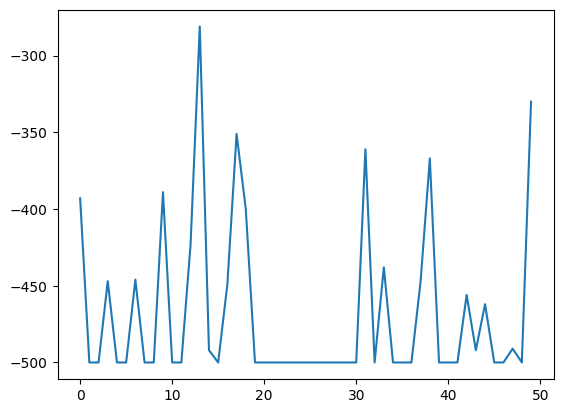


Recompensa de Media: -468.3 



In [111]:
# Evaluamos al Generador 
rewardMean=gan8.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 9


### Construcción de base de datos con 9 trayectoria

In [112]:
expert_observations = np.genfromtxt("observations_Acrobot_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.7708520e-01 -2.1284866e-01 -9.9287670e-01  1.1914617e-01
   4.5034285e+00 -3.0504138e+00]
 [ 7.8630270e-01  6.1784140e-01 -6.9435540e-01  7.1963220e-01
   4.1033060e+00 -3.7541158e+00]
 [ 1.9867054e-01  9.8006636e-01 -6.0039040e-03  9.9998200e-01
   2.9054150e+00 -3.7331226e+00]]
	Acciones reales: 
 [0 0 0 ... 0 1 1]


In [113]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 8)
print(longitud_trayectoria)

4275


In [114]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [115]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.6230960e-01 -2.7195640e-01 -8.4543127e-01 -5.3408426e-01
  -1.3917240e+00 -2.2916570e+00]
 [ 8.6455953e-01 -5.0253046e-01 -9.9526850e-01 -9.7162460e-02
  -1.0388322e+00 -2.5217462e+00]
 [ 7.9294574e-01 -6.0929227e-01 -8.6828210e-01  4.9607083e-01
  -1.6565110e-01 -3.7694914e+00]]
	Acciones reales: 
 [0 0 0 ... 1 0 1]


### Separación de Train y Test

In [116]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997245  -0.02347029  0.9999985  ...  1.          0.
   0.        ]
 [ 0.9999358  -0.01132928  0.99917394 ...  1.          0.
   0.        ]
 [ 0.99959403  0.02849232  0.98998153 ...  1.          0.
   0.        ]
 ...
 [ 0.9623096  -0.2719564  -0.84543127 ...  0.          1.
   0.        ]
 [ 0.86455953 -0.50253046 -0.9952685  ...  1.          0.
   0.        ]
 [ 0.79294574 -0.60929227 -0.8682821  ...  0.          1.
   0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3420
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 855


In [117]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [118]:
gan9=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [119]:
tf.config.run_functions_eagerly(True)
gan9.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [120]:
!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [121]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

# Realiza 300 iteraciones con los datos de entrenamiento: la división da 0.8, he aproximado a 1 aunque realicemos menos de 300 iteraciones con los datos 
BATCH_SIZE= round(len(X_train)/300)

history=gan9.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)

311/311 [==============================] - 9992s 32s/step - d_loss: 1.9020 - g_loss: 1.2042


### Evaluación de GAIL

In [122]:
# Evaluamos el Discriminador de GAIL en el TEST
gan9.evaluate_D(X_test)

1/1 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
8.36556546257583e-10
>Loss fake: 
0.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


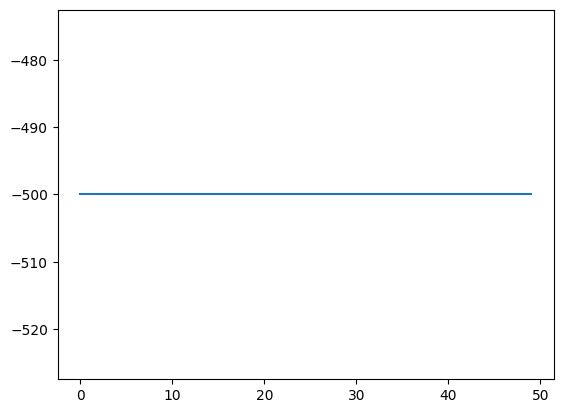


Recompensa de Media: -500.0 



In [123]:
# Evaluamos al Generador 
rewardMean=gan9.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 10


### Construcción de base de datos con 1 trayectoria

In [124]:
expert_observations = np.genfromtxt("observations_Acrobot_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.7708520e-01 -2.1284866e-01 -9.9287670e-01  1.1914617e-01
   4.5034285e+00 -3.0504138e+00]
 [ 7.8630270e-01  6.1784140e-01 -6.9435540e-01  7.1963220e-01
   4.1033060e+00 -3.7541158e+00]
 [ 1.9867054e-01  9.8006636e-01 -6.0039040e-03  9.9998200e-01
   2.9054150e+00 -3.7331226e+00]]
	Acciones reales: 
 [0 0 0 ... 0 1 1]


In [125]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 9)
print(longitud_trayectoria)

4587


In [126]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [127]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 9.9972450e-01 -2.3470292e-02  9.9999850e-01 -1.7193710e-03
  -2.0451218e-02 -1.3121777e-02]
 [ 9.9993580e-01 -1.1329277e-02  9.9917394e-01 -4.0638402e-02
   1.3795651e-01 -3.6711946e-01]
 [ 9.9959403e-01  2.8492324e-02  9.8998153e-01 -1.4119682e-01
   2.4875222e-01 -6.1888070e-01]
 ...
 [ 9.7708520e-01 -2.1284866e-01 -9.9287670e-01  1.1914617e-01
   4.5034285e+00 -3.0504138e+00]
 [ 7.8630270e-01  6.1784140e-01 -6.9435540e-01  7.1963220e-01
   4.1033060e+00 -3.7541158e+00]
 [ 1.9867054e-01  9.8006636e-01 -6.0039040e-03  9.9998200e-01
   2.9054150e+00 -3.7331226e+00]]
	Acciones reales: 
 [0 0 0 ... 0 1 1]


### Separación de Train y Test

In [128]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.9997245  -0.02347029  0.9999985  ...  1.          0.
   0.        ]
 [ 0.9999358  -0.01132928  0.99917394 ...  1.          0.
   0.        ]
 [ 0.99959403  0.02849232  0.98998153 ...  1.          0.
   0.        ]
 ...
 [ 0.9770852  -0.21284866 -0.9928767  ...  1.          0.
   0.        ]
 [ 0.7863027   0.6178414  -0.6943554  ...  0.          1.
   0.        ]
 [ 0.19867054  0.98006636 -0.0060039  ...  0.          1.
   0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3669
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 918


In [129]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [130]:
gan10=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [131]:
tf.config.run_functions_eagerly(True)
gan10.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

In [132]:
expert_rewards = expert_rewards.reshape(-1, 1)!export CUDA_LAUNCH_BLOCKING=1

### Entrenamiento de GAIL

In [133]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

# Realiza 300 iteraciones con los datos de entrenamiento: la división da 0.8, he aproximado a 1 aunque realicemos menos de 300 iteraciones con los datos 
BATCH_SIZE= round(len(X_train)/300)

history=gan10.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)

306/306 [==============================] - 10022s 33s/step - d_loss: 1.8977 - g_loss: 1.1836


### Evaluación de GAIL

In [134]:
# Evaluamos el Discriminador de GAIL en el TEST
gan10.evaluate_D(X_test)

1/1 [==============================] - 0s 13ms/step - loss: 1.3187e-10 - accuracy: 0.0000e+00
>Loss real: 
7.142170188600971e-10
>Loss fake: 
1.3186869651793387e-10


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


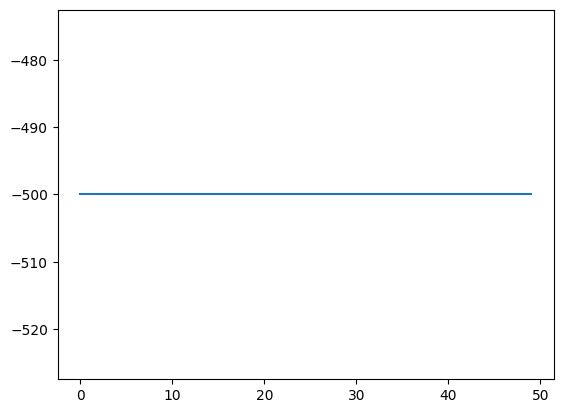


Recompensa de Media: -500.0 



In [135]:
# Evaluamos al Generador 
rewardMean=gan10.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')